In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from math import ceil
import tensorflow as tf
from tensorflow import keras as keras
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop,SGD,Adadelta,Adam,Nadam

from keras import backend as K
from keras.callbacks import *
from tensorflow.keras.backend import clear_session

from clr_callback import *


from tensorflow.keras.callbacks import TensorBoard



import seaborn as sns
import matplotlib.pyplot as plt 

C:\ProgramData\Anaconda3\envs\tensorflow_36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow_36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow_36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow_36\lib\s

### Loading the data ###

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Splitting the data in three different datasets for training, validation and testing ###

In [4]:
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [5]:
valid_images = test_images[:5000]
valid_labels = test_labels[:5000]
test_images = test_images[5000:]
test_labels = test_labels[5000:]

In [6]:
print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape,valid_labels.shape,test_labels.shape)

(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)
(60000,) (5000,) (5000,)


### Displaying some of the images ###

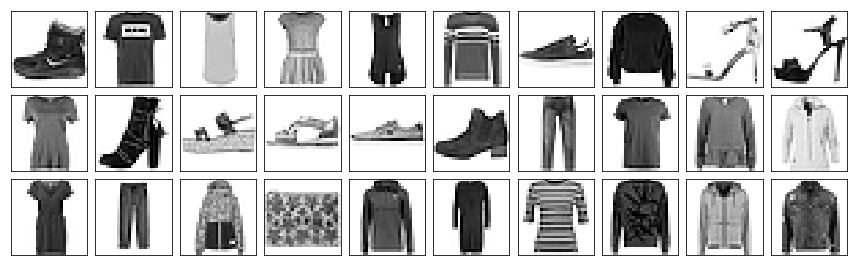

In [7]:
def show_images(images):
    """Show images in a grid
    """
    n_rows = ceil(len(images) / 10)
    fig, ax = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, _ in enumerate(images):
        ax[i // 10, i % 10].imshow(images[i].reshape(28, 28), cmap='Greys')

show_images(train_images[:30])
plt.show();

Fixing the seed to get reproducible results.

In [8]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [9]:
img_rows, img_cols = 28, 28

train_images_cnn = train_images
test_images_cnn = test_images
valid_images_cnn = valid_images

**Setting up the basic parameters of the model**

We set the batch size to 128 and the number of epochs to 10. As there are 10 different categories in the fashionMNIST we set the value to 10.

In [10]:
input_size = 784

n_classes = 10 
n_epochs=10
batch_size=128

**Input formatting**

In [11]:
if K.image_data_format() == 'channels_first':   
    train_images_cnn = train_images_cnn.reshape(train_images_cnn.shape[0], 1, img_rows, img_cols)
    test_images_cnn = test_images_cnn.reshape(test_images_cnn.shape[0], 1, img_rows, img_cols)
    valid_images_cnn = valid_images_cnn.reshape(valid_images_cnn.shape[0], 1, img_rows, img_cols)
    #all_images_cnn = train_images.reshape(train_images.shape[0],1,img_rows,img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images_cnn = train_images_cnn.reshape(train_images_cnn.shape[0],  img_rows, img_cols,1)
    test_images_cnn = test_images_cnn.reshape(test_images_cnn.shape[0],  img_rows, img_cols,1)
    valid_images_cnn = valid_images_cnn.reshape(valid_images_cnn.shape[0],  img_rows, img_cols,1)
    #all_images_cnn = train_images.reshape(train_images.shape[0],img_rows,img_cols,1)
    input_shape = (img_rows, img_cols, 1)
    
train_images_cnn = train_images_cnn.astype('float32')
test_images_cnn = test_images_cnn.astype('float32')
valid_images_cnn = valid_images_cnn.astype('float32')

train_images_cnn /= 255
test_images_cnn /= 255
valid_images_cnn /= 255

print('valid image shape:', valid_images_cnn.shape)
print('valid label shape:', valid_labels.shape)
print('test shape:', test_images_cnn.shape)
print('test label shape before one-hot:', test_labels.shape)
print(train_images_cnn.shape[0], 'train samples')
print(test_images_cnn.shape[0], 'test samples')

valid image shape: (5000, 28, 28, 1)
valid label shape: (5000,)
test shape: (5000, 28, 28, 1)
test label shape before one-hot: (5000,)
60000 train samples
5000 test samples


**One-hot encoding**

In [12]:
train_labels = keras.utils.to_categorical(train_labels, n_classes)
valid_labels = keras.utils.to_categorical(valid_labels, n_classes)
test_labels = keras.utils.to_categorical(test_labels, n_classes)

print('valid label shape after one-hot:', valid_labels.shape)
print('test label shape after one-hot:', test_labels.shape)

valid label shape after one-hot: (5000, 10)
test label shape after one-hot: (5000, 10)


**Setting up a basic model**

Our first, basic model has 2 convolutional layers and 2 max pooling layers and finally a flatten layer. The batchsize is set to 64, epoch is 10. The activation function is linear except for the final flatten layer. As this is a basic model I did not add any dropout layers.

In [13]:
input_size = 784

n_classes = 10 
n_epochs=10
batch_size=64

model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='linear',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 114,378
Trainable params: 114,378
Non-trainable params: 0
_________________________________________________________________


First let's set up a relatively large learning rate

In [14]:
adam_opt_large_lr = Adam(0.1)

Compiling and fitting the model

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy, 
                     optimizer=adam_opt_large_lr,
                     metrics=['accuracy'])

history = model.fit(train_images_cnn, train_labels,
      batch_size=batch_size,
      epochs=n_epochs,
      verbose=1,
      validation_data=(valid_images_cnn, valid_labels))

score = model.evaluate(test_images_cnn, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 5000 samples
Epoch 1/10
60000/60000 [==============================] - 69s 1ms/step - loss: 14.4925 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 2/10
60000/60000 [==============================] - 70s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 3/10
60000/60000 [==============================] - 68s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 4/10
60000/60000 [==============================] - 67s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 5/10
60000/60000 [==============================] - 69s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 6/10
60000/60000 [==============================] - 70s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4837 - val_acc: 0.1014
Epoch 7/10
60000/60000 [==============================] - 70s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.4

**Displaying the results of the first model**

In [16]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

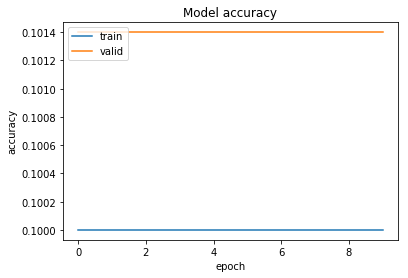

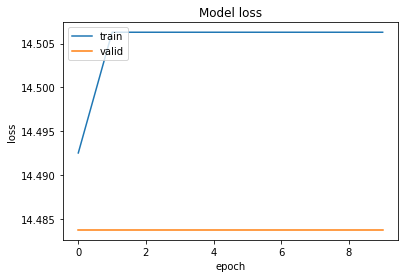

In [17]:
display_history(history)

***

### Setting up an advanced model ###

In my next model I add a dropout layer to the previous model and also change the activation function from linear to relu. I also increased the batch size. I also decreased the learning rate size.

In [35]:
adam_opt = Adam()

input_size = 784

n_classes = 10 
n_epochs=10
batch_size=128


model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          102464    
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                10250     
Total para

In [36]:
model.compile(loss=keras.losses.categorical_crossentropy, 
                     optimizer=adam_opt,
                     metrics=['accuracy'])

history = model.fit(train_images_cnn, train_labels,
      batch_size=batch_size,
      epochs=n_epochs,
      verbose=1,
      validation_data=(valid_images_cnn, valid_labels))

score = model.evaluate(test_images_cnn, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 5000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/step - loss: 0.5633 - acc: 0.8007 - val_loss: 0.4452 - val_acc: 0.8530
Epoch 2/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.3636 - acc: 0.8703 - val_loss: 0.3542 - val_acc: 0.8832
Epoch 3/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.3156 - acc: 0.8883 - val_loss: 0.3393 - val_acc: 0.8832
Epoch 4/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2909 - acc: 0.8963 - val_loss: 0.3234 - val_acc: 0.8874
Epoch 5/10
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2696 - acc: 0.9038 - val_loss: 0.2975 - val_acc: 0.8992
Epoch 6/10
60000/60000 [==============================] - 74s 1ms/step - loss: 0.2546 - acc: 0.9077 - val_loss: 0.2898 - val_acc: 0.8984
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2408 - acc: 0.9128 - val_loss: 0.2781 - val_acc:

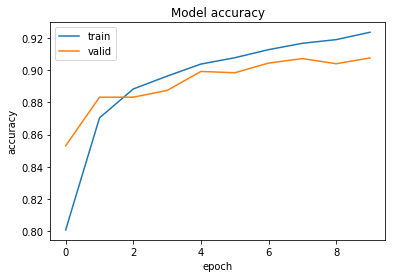

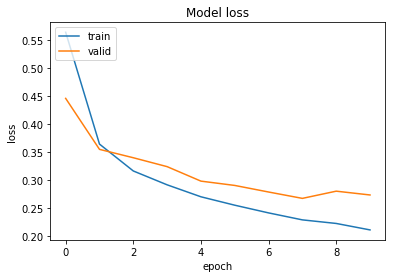

In [37]:
display_history(history)

***

### More advanced model with adaptive and cyclical learning rate ###

As my last try I have added a convolutional layer I changed the width of the layers and set the activation function to leaky relu with an alpha of 0.1. I also added more dropout layers to the model. The optimizer is adaptive Adam and I also added a cyclical learning rates in the callbacks to the model. I also increased the number of epochs to get the best results.

In [38]:
adam_opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

input_size = 784

n_classes = 10 
n_epochs=20
batch_size=256

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(n_classes, activation='softmax'))

In [39]:
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000.)
clr_triangular = CyclicLR(mode='triangular')

model.compile(loss=keras.losses.categorical_crossentropy, 
                     optimizer=adam_opt,
                     metrics=['accuracy'])


history = model.fit(train_images_cnn, train_labels,callbacks=[clr_triangular],
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_data=(valid_images_cnn, valid_labels))
score = model.evaluate(test_images_cnn, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 97s 2ms/step - loss: 0.7009 - acc: 0.7404 - val_loss: 0.4106 - val_acc: 0.8524
Epoch 2/20
60000/60000 [==============================] - 98s 2ms/step - loss: 0.4039 - acc: 0.8530 - val_loss: 0.3334 - val_acc: 0.8742
Epoch 3/20
60000/60000 [==============================] - 95s 2ms/step - loss: 0.3465 - acc: 0.8730 - val_loss: 0.3060 - val_acc: 0.8880
Epoch 4/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.3148 - acc: 0.8847 - val_loss: 0.2977 - val_acc: 0.8888
Epoch 5/20
60000/60000 [==============================] - 105s 2ms/step - loss: 0.3047 - acc: 0.8875 - val_loss: 0.2736 - val_acc: 0.9000
Epoch 6/20
60000/60000 [==============================] - 99s 2ms/step - loss: 0.2931 - acc: 0.8908 - val_loss: 0.3010 - val_acc: 0.8908
Epoch 7/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2903 - acc: 0.8916 - val_loss: 0.2687 - val_a

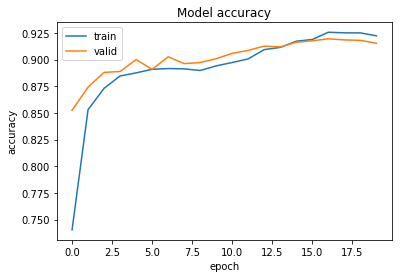

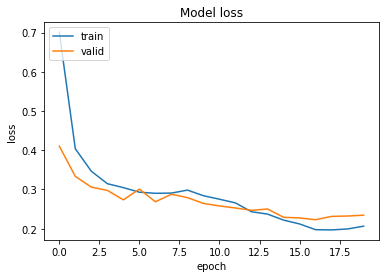

In [40]:
display_history(history)

Saving the model.

In [41]:
model.save("fashion_mnist_model.h5py")

### Predicting the labels ###

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
predicted_classes = model.predict(test_images_cnn)

Converting the highest number/probability to class label

In [45]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
test_labels_classes = np.argmax(test_labels, axis=1)

In [50]:
predicted_classes.shape, test_labels_classes.shape

((5000,), (5000,))

### Displaying the normalized confusion matrix ###

In [71]:
cm = confusion_matrix(test_labels_classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [74]:
class_list = ["Class 0", "Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7",\
              "Class 8","Class 9"]

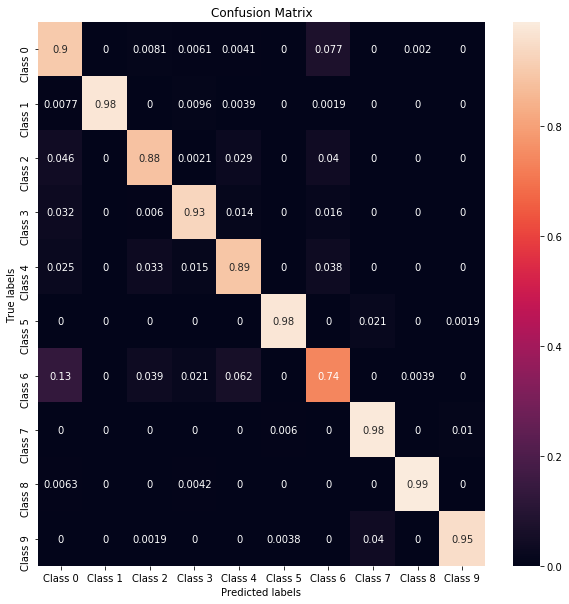

In [72]:
plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_list); ax.yaxis.set_ticklabels(class_list);

### Showing the incorrect guesses ###

Found 386 incorrect labels


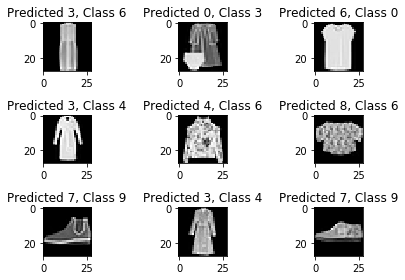

In [59]:
incorrect = np.where(predicted_classes!=test_labels_classes)[0]
print("Found {} incorrect labels".format(len(incorrect)))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images_cnn[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels_classes[incorrect]))
    plt.tight_layout()

By looking at a few images I can't realy tell why is the model not able to classify the above pictures. To me the 1st and 4th pictures seem identical (just as the model predicted) but it turns out that they are not.

### Final thougths ###

As we could see I started with a basic model with very poor results and I ended up with an almost 93% model. In order to achieve it I have changed the architecture of the model, added dropout layers also increased the batch size and used adaptive and cyclic learning rate.
Overall I am OK with the results achieved. 